# Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)
import state_space as ss
import statsmodels.api as sm
import sympy as sym
import typing as tp

In [4]:
from state_space import (
    SymbolicStateSpaceModelViaMaximumLikelihood, 
    IndependentParameterTransformation, 
    LambdaUnivariateTransformation)

In [6]:
plt.rcParams["figure.figsize"] = (18,12)

In [7]:
pd.set_option('display.max_rows', 250)

# Read Data

## Returns

In [8]:
# spy_filename = os.path.join('data', 'GSPC_daily.csv')
spy_filename = os.path.join('data', 'SPY_daily.csv')

In [9]:
df = pd.read_csv(spy_filename)

In [10]:
df['Date'] = pd.to_datetime(df['Date'])

In [11]:
df.sort_values('Date', inplace=True)

In [12]:
df = df.dropna()

In [13]:
df['Log_Return'] = np.log(df['Close']).diff()

In [14]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Log_Return
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,26.583992,1003200,NaN
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,26.773048,480500,0.007087
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,26.829773,201300,0.002116
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,27.113388,529400,0.010515
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,27.226835,531500,0.004175


## Factor Data

In [15]:
factor_filename = os.path.join('data', 'F-F_Research_Data_Factors_daily.CSV')

In [16]:
factors \
    = pd.read_csv(factor_filename, 
                  engine='python', 
                  skiprows=5, 
                  names=['Date', 'Mkt-RF', 'SMB', 'HML', 'RF'], 
                  skipfooter=1)
factors['Date'] = pd.to_datetime(factors['Date'], format='%Y%m%d')
factors['RF'] *= 0.01
factors = factors.dropna()

## Merge Returns and Risk-Free Rate

In [17]:
df = df.merge(factors.loc[:, ['Date', 'RF']], on='Date')

In [18]:
df['Excess_Return'] = df['Log_Return'] - np.log(1.0 + df['RF'])

In [19]:
df = df.dropna()

## Extract Time-Series

Equity returns

In [20]:
# log_returns = np.log(df['Close']).diff().dropna().values
log_returns = np.log(df['Close']).diff().values

Risk-free Rate

In [21]:
r = np.log(1.0 + (df['RF'].values))

Compute excess returns

In [22]:
excess_returns = df['Excess_Return'].values

# Time-Series Model

## Stochastic Process

Assume that the (unobserved) equity premium $\mu_t$ follwos the autoregressive process  

$\mu_{t+1} = \alpha + \beta \mu_t + \eta_{t+1}$,  

where $\alpha, \beta \in \mathbb{R}$ and $\{\eta\}_{t=1}^T$ is a sequence of i.i.d. normal shocks with mean zero and variance $\sigma_{\eta}^2$.

The (observed) log return $r_t$ is generated via  

$r_t = r_{f, t} + \mu_t + \epsilon_t$,  

where $r_{f, t}$ is the risk-free rate at time $t$ and $\{\epsilon\}_{t=1}^T$ is a sequence of i.i.d. normal shocks with mean zero and variance $\sigma_{\epsilon}^2$.

Subtracting the risk-free rate, we obtain the following process for the log excess return:

$x_t = r_t - r_{f, t} = \mu_t + \epsilon_t$.

## Linear State Space Representation and Kalman Filter

See https://www.statsmodels.org/stable/statespace.html

The time-varying equity premium model is a linear state space model of the form  

$$
\begin{align*}
s_{t+1} & = T_t s_t + c_t + R_t \eta_{t+1} \text{ (state equation)} \\
y_t & = Z_t s_t + d_t + \epsilon_t \text{ (observation equation)},
\end{align*}
$$
where  
$$
\begin{align*}
\epsilon_t & \sim N(0, H_t) \\
\eta_t & \sim N(0, Q_t).
\end{align*}
$$
In this time-varying equity premium model, the observation $y_t$ is the log return $x_t$ and the state $\alpha_t$ is the equity premium $\mu_t$. The coefficients specific to this model are given by  
$$
\begin{align*}
Z_t & = 1 \\
R_t & = 1 \\
T_t & = \beta_{\mu} \\
H_t & = \sigma^2 \\
Q_t & = \sigma_{\mu}^2 \\
c_t & = \alpha_{\mu}
\end{align*}
$$
All other coefficients are zero and we obtain  
$$
\begin{align*}
\mu_{t+1} & = \beta_{\mu} \mu_t + \alpha_{\mu} + \eta_t \text{ (state equation)} \\
x_t & = \mu_t + \epsilon_t \text{ (observation equation)},
\end{align*}
$$

## Representing Coefficients in SymPy and Building the Symbolic State Space Model

Construct parameter symbols (this is used to teell  State Space which parameters are to be estimated via MLE)

In [23]:
parameter_symbols = \
    sym.symbols(('alpha.mu',
                 'beta.mu',
                 'sigma2',
                 'sigma2.mu'))

alpha_mu, beta_mu, sigma_2, sigma_2_mu = parameter_symbols

Construct coefficient vectors and matrices

In [24]:
H = sym.Matrix([sigma_2])
Q = sym.Matrix([sigma_2_mu])
c = sym.Matrix([alpha_mu])
T = sym.Matrix([beta_mu])
Z = sym.Matrix.ones(rows=1, cols=1)
R = sym.Matrix.ones(rows=1, cols=1)

Define the state vector

In [25]:
state_vector_symbols = tuple([sym.Symbol('mu')])

Map data symbols (return) to data arrays (NumPy or Pandas series)

In [26]:
y = sym.Symbol('y')
data_symbol_to_data_map = {y: excess_returns}

Set starting values for the numerical optimization

In [27]:
excess_return_variance = np.var(excess_returns)
parameter_symbols_to_start_parameters_map = \
    {alpha_mu: 0.0,
     beta_mu: 0.0,
     sigma_2: excess_return_variance,
     sigma_2_mu: excess_return_variance}

Define transformations so that the numerical optimizer can operate in an unconstrained parameter space

In [28]:
squared_univariate_transform = \
    LambdaUnivariateTransformation(
        transform_function=lambda x: x**2,
        untransform_function=lambda x: x**0.5)

parameter_transformation = \
    IndependentParameterTransformation(
        parameter_symbols=parameter_symbols,
        parameter_symbol_to_univariate_transformation_map
        ={sigma_2: squared_univariate_transform,
          sigma_2_mu: squared_univariate_transform})

Compile the symbolic definition to the statsmodels format for numeric MLE

In [29]:
time_varying_equity_premium_model = \
    SymbolicStateSpaceModelViaMaximumLikelihood(parameter_symbols=parameter_symbols,
                                                state_vector_symbols=state_vector_symbols,
                                                observation_vector_symbols=tuple([y]),
                                                data_symbol_to_data_map=data_symbol_to_data_map,
                                                parameter_symbols_to_start_parameters_map
                                                =parameter_symbols_to_start_parameters_map,
                                                parameter_transformation=parameter_transformation,
                                                design_matrix=Z,
                                                selection_matrix=R,
                                                transition_matrix=T,
                                                state_intercept_vector=c,
                                                state_covariance_matrix=Q,
                                                observation_covariance_matrix=H)

# Estimation

In [31]:
result = time_varying_equity_premium_model.fit(disp=False)
print(result.summary())

                                        Statespace Model Results                                       
Dep. Variable:                                               y   No. Observations:                 6738
Model:             SymbolicStateSpaceModelViaMaximumLikelihood   Log Likelihood               20553.207
Date:                                         Sun, 09 Feb 2020   AIC                         -41098.413
Time:                                                 22:41:03   BIC                         -41071.152
Sample:                                                      0   HQIC                        -41089.001
                                                        - 6738                                         
Covariance Type:                                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
alpha.mu  

Filtered equity premium

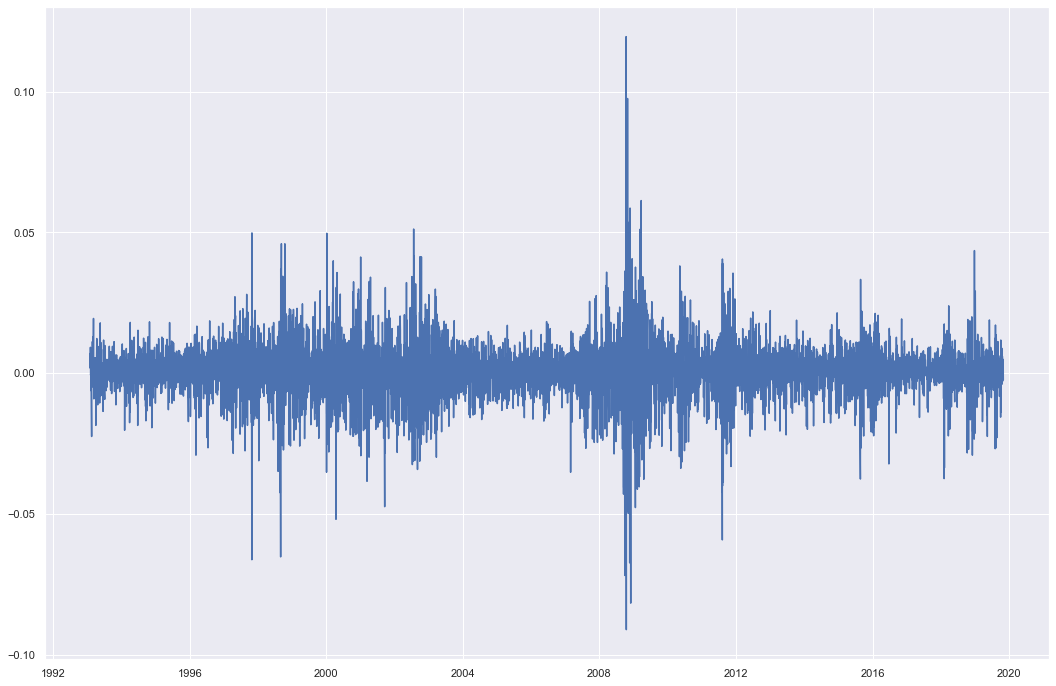

In [32]:
plt.plot(df['Date'], result.filtered_state[0, :]);

Smoothed equity premium

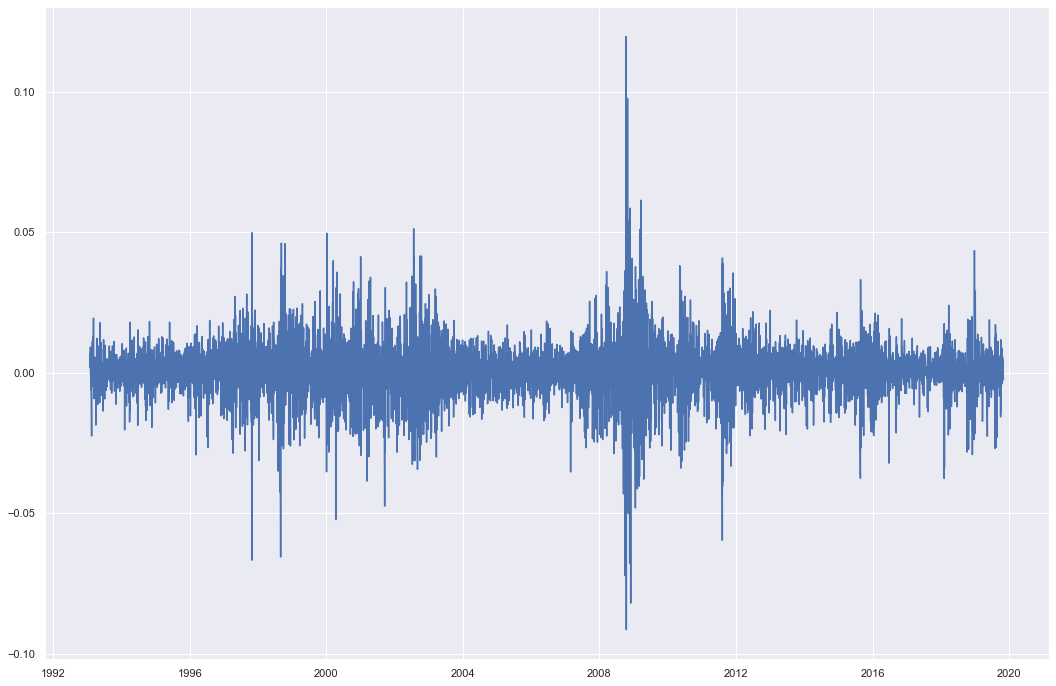

In [33]:
plt.plot(df['Date'], result.smoothed_state[0, :]);